<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · Pràctica</p>
<p style="margin: 0; text-align:right;">2019-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Sistema automàtic per la detecció de COVID-19 en radiografies

Una de les applicacions de AI és el processament de imatges mèdiques. En particular, l'ús de les radiografies per una detecció no invasiva i ràpida del Covid-19 pot resultar extremadament útil per ajudar i agilitzar la tasca del personal mèdic [1][2].

En aquest projecte desenvoluparem un detector *Deep Learning* de Covid-19 en radiografies. Per això, utilitzarem imatges de la base de dades "Covid-chestxray-dataset" [3], generada per uns investigadors del grup de recerca [Mila](https://mila.quebec/en/) i de la Universitat de Montreal [4]. També farem servir imatges de radiogradies de pacients sans i amb pneumonia bacterial extretes de la competició de Kaggle "Chest X-Ray Images (Pneumonia)" [5].


En total, disposem d'un total de 426 imatges, dividides en conjunts d'entrenament (339 imatges), validació (42 imatges) i test (45 imatges).
Les particions es donen en llistes ".txt", on a cada imatge se li assigna una etiqueta:
- 0) Healthy
- 1) Covid-19
- 2) Pneumonia

L'objectiu consisteix en desenvolupar un sistema basat en xarxes neuronals capaç de classificar correctament les imatges en aquestes 3 categories.

**<u>Nota</u>**: Els resultats obtinguts per models entrenats en aquesta base de dades són purament per finalitats educatives i no es poden fer servir per un diagnòstic real sense validació clínica.



#### Referències
1. María Climent, 2020 [Covid-19: La Inteligencia Artificial De La Española Quibim Puede Acelerar El Diagnóstico Del Coronavirus](https://innovadores.larazon.es/es/esta-inteligencia-artificial-espanola-puede-acelerar-el-diagnostico-del-coronavirus/)
2. Angel Alberich-bayarri,2020 [Imagin, AI and Radiomix to understand and fight Coronavirus Covid-19](https://quibim.com/2020/02/14/imaging-ai-and-radiomics-to-understand-and-fight-coronavirus-covid-19/)
3. [Ieee8023/covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset)
4. Cohen, J.P., Morrison, P. and Dao, L., 2020. [COVID-19 image data collection](https://arxiv.org/pdf/2003.11597.pdf).
5. Paul Mooney, 2019 [Chest X-ray Images (pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


# Introducció

Aplicarem un *pipeline* de *machine learning* amb les
següents etapes:

1. Lectura, anàlisi exploratori i preprocessament de les dades.
2. Construcció dels models de *Deep Learning* amb diferent arquitectures.
3. Entrenament i validació dels models que permetrà seleccionar els que obtenen millor precisió i rendiment.
4. Avaluació dels models amb les dades de *test* per a verificar el seu poder de generalització amb dades no vistes durant l'entrenament.
5. Explicació aplicant tècniques de visualització de dades. 

Crearem classes de Python per a encapsular les diferents tasques. Aquest disseny orientat a objectes ens permetrà modularitzar i reduir l'acoplament entre les diferents fases del *pipeline* facilitant l'experimentació amb diferent paràmetres al reduir el risc de que la modificació d'una part afecti a la resta. De fet, l'ambició és construïr un petit *framework* que pugui ser utilitzat per a altres tasques d'anàlisis d'imatges amb poques adaptacions.

Tot el codi s'ha executat en un entorn Google Colab amb processadors GPU i les següents llibreries:

* *Pillow* per al processament d'imatges. És un fork de Python Image Library, PIL.
* *Numpy*, *Pandas* i *Sklearn* per a la manipulació de dades.
* *Tensorflow* i *Keras* per a la construcció i ús de xarxes neuronals.
* *Vis* per a la visualització de mapes d'activació de classes (*class activation maps*, CAM).


# Lectura, anàlisi exploratori i preparació del Dataset (3 punts)

En aquest primer apartat s'analitzaran les imatges de la base de dades i es disenyarà un *pipeline* per carregar les imatges i preparar-les per la xarxa neuronal. 

Dissenyarem una classe anomenada *CovidXRayImageReader* que encapsularà les operacions de lectura i
preprocessament de les imatges de les radigràfies.

La classe llegeix els fitxers d'índex *training.txt*, *validation.txt* i *testing.txt* generant un dataframe per a cadascú d'ells. Les columnes del dataframe són: la ruta del fitxer de la imatge, el array de píxels de la imatge amb dimensions 224x224x3, el tamany original, la classe i l'etiqueta corresponent: classe 0, etiqueta HEALTHY; classe 1, etiqueta COVID-19 i classe 2, etiqueta PNEUMONIA. Les imatges només es llegeixen la primera vegada que s'accedeix a un dataframe, ja que *memoitzem* els dataframes en un atribut de la classe de tipus diccionari millorant considerablement el rendiment en els accessos consecutius a les imatges. Com es comprovarà posteriorment aquests dataframes faciliten molt l'exploració i manipulació de les dades.

La classe també facilita el preprocessament de les imatges, aplicant les següents operacions que s'explicaràn després:

* Normalització: totes les imatges es redimensionaràn a tamany 224x224 amb format RGB obtenint tensors de 8 bits amb dimensions 224x224x3. Més endavant es normalitzaràn els pixels de 8 bits a valors de l'interval [0,1] per al seu processament pels models de xarxes neuronals.
* Augmentació de dades. S'augmentarà el dataset d'entrenament aplicant transformacions aleatòries a les imatges originals: rotacions, zoom, desplaçaments i inversions.

A continuació es mostra el codi de la classe i després anirem explicant els principals mètodes que s'usaran per a preprocessar i analitzar les imatges.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import keras
from PIL import Image
import os

DIRECTORY = 'DATASET'
DATASETS = 'training', 'testing', 'validation'
IMAGE_SIZE = (224,224)
SAMPLES = 5
SEED = 42

# Canvia el directori de treball al del datasets
# Si s'executa en un entorn Google Colab monta l'unitat de
# Google Drive on són els datasets
def chdir_dataset(directory):
        try:
            from google.colab import drive
            base = '/content/drive'
            drive.mount(base)
            directory = base + '/My Drive/' + directory
        except: pass
        os.chdir(directory)

class CovidXRayImageReader:
    def __init__(self):
        self.datasets, self.classes = {}, {}
        for ds in DATASETS:
            self.datasets[ds] = self.load_dataset(ds)
                    
    def load_dataset(self, ds):
        data = []
        filename = ds+'.txt'
        with open(filename, mode='rt') as file:
            for line in file:
                class_idx, image_path = line.strip().split('\t')
                class_idx = int(class_idx)
                label = image_path.split('/',2)[0]
                self.classes[class_idx] = label
                image, orig_size = self.load_image(image_path, resize=IMAGE_SIZE)
                data.append([image_path, image, orig_size, label, class_idx])
            print('Read', str(len(data)), 'images from', filename)
        df = self.create_dataframe(data)
        return sklearn.utils.shuffle(df)

    def create_dataframe(self, data):
        columns = 'image_path', 'image', 'original_size', 'label', 'class'
        return pd.DataFrame(data, columns=columns)

    def augment_training_images(self, factor=3):
        dir_name = 'augmented'
        dataset = self.get_dataset('training')
        if not os.path.exists(dir_name):
            batch_size = 128
            os.mkdir(dir_name)
            img_gen = ImageDataGenerator(
                          rotation_range=15, 
                          zoom_range=0.3,
                          width_shift_range=0.2, 
                          height_shift_range=0.2, 
                          shear_range=0.2, 
                          horizontal_flip=True,
                          fill_mode='nearest'
                      )
            for class_,label in zip(self.get_classes(), self.get_labels()):
                i = 0
                df = dataset[dataset['label']==label]
                number = df.shape[0] * factor
                for image_batch in img_gen.flow_from_dataframe(
                    df,
                    x_col='image_path',
                    y_col='class',
                    class_mode=None,
                    save_to_dir=dir_name,
                    save_prefix= str(class_) + '_' + label + '_augmented_',
                    save_format='png'):
                    i+= batch_size
                    print('Data augmentation:', i, 'images generated...')
                    if i >= number: break
        data = []
        for image_name in os.listdir(dir_name):
            class_, label = image_name.split('_')[:2]
            image_path = dir_name + '/' + image_name
            image, size = self.load_image(image_path, resize=IMAGE_SIZE)
            data.append([image_path, image, size, label, class_])
        df = self.create_dataframe(data)
        self.datasets['augmented'] = sklearn.utils.shuffle(pd.concat([dataset,df]))

    def load_image(self, path, resize=None, scale=None):
        image = Image.open(path).convert(mode='RGB')
        orig_size = image.size
        if resize is not None: image = image.resize(resize)
        image = np.array(image)
        if scale is not None: image = image*scale
        return image, orig_size

        np.array(Image.open(path).convert(mode='RGB').resize(size))
    
    def get_dataset(self, *ds_names, label='', number=None):
        dataset = pd.concat([self.datasets[ds] for ds in ds_names])
        if label != '': dataset = dataset[dataset['label']==label]
        if number is not None: dataset = dataset.head(number)
        return dataset 

    def get_dataset_names(self):
        return list(self.datasets.keys())
    
    def get_classes(self):
        return list(sorted(self.classes.keys()))

    def get_labels(self):
        return list([self.classes[key] for key in self.get_classes()])
   
    def plot_image_samples(self, samples=5):
        for label in self.get_labels():
            _, axs = plt.subplots(1, samples, figsize=(15,15))
            dataset = self.get_dataset('augmented', label=label, number=samples)
            for ax, (_, row) in zip(axs, dataset.iterrows()):
                ax.imshow(row['image'])
                ax.set_title(row['label'])
                ax.axis('off')
                
    def get_statistics(self):
        dataset_names = self.get_dataset_names()
        labels = self.get_labels()
        datasets = [self.get_dataset(ds) for ds in dataset_names]
        stats = []
        for name,dataset in zip(dataset_names, datasets):
            for label in labels:
                count = dataset[dataset['label']==label].shape[0]
                stats.append([name[0].upper()+name[1:], label, count])
        return pd.DataFrame(stats, columns=['Dataset', 'Diagnostic', 'Count'])
                
    def plot_statistics(self):
        df = self.get_statistics().pivot('Dataset', 'Diagnostic', 'Count')
        df.plot.barh(stacked=True, figsize=(12,5))
        plt.show()

Using TensorFlow backend.


A continuació instanciem la class *CovidXRayImageReader* per a llegir les imatges i presentem una mostra del conjunt de dades d'entrenament. 

La funció *chdir_dataset* canvia el directori de treball al que conté les imatges. Si s'utilitza en un entorne d'execució Google Colab llegeix les dades de Google Drive.

In [0]:
np.random.seed(SEED)
chdir_dataset(DIRECTORY)
img_reader = CovidXRayImageReader()
img_reader.get_dataset('training').head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Read 339 images from training.txt
Read 45 images from testing.txt
Read 42 images from validation.txt


,image_path,image,original_size,label,class
284,HEALTHY/IM-0392-0001.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(1442, 1059)",HEALTHY,0
116,COVID-19/covid-19-pneumonia-mild.JPG,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(867, 772)",COVID-19,1
113,COVID-19/41591_2020_819_Fig1_HTML.webp-day10.png,"[[[103, 103, 103], [36, 36, 36], [11, 11, 11],...","(255, 249)",COVID-19,1
42,PNEUMONIA/person402_bacteria_1809.jpeg,"[[[22, 22, 22], [24, 24, 24], [25, 25, 25], [2...","(848, 496)",PNEUMONIA,2
126,COVID-19/FE9F9A5D-2830-46F9-851B-1FF4534959BE....,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...","(1024, 1024)",COVID-19,1
231,HEALTHY/IM-0444-0001.jpeg,"[[[11, 11, 11], [18, 18, 18], [29, 29, 29], [3...","(1928, 1754)",HEALTHY,0
181,COVID-19/ciaa199.pdf-001-c.png,"[[[69, 69, 69], [77, 77, 77], [72, 72, 72], [7...","(466, 397)",COVID-19,1
278,HEALTHY/NORMAL2-IM-1225-0001.jpeg,"[[[0, 0, 0], [9, 9, 9], [18, 18, 18], [26, 26,...","(1676, 1129)",HEALTHY,0
336,HEALTHY/NORMAL2-IM-1117-0001.jpeg,"[[[0, 0, 0], [0, 0, 0], [94, 94, 94], [168, 16...","(1466, 1265)",HEALTHY,0
25,PNEUMONIA/person294_bacteria_1384.jpeg,"[[[206, 206, 206], [203, 203, 203], [212, 212,...","(1024, 688)",PNEUMONIA,2


S'observa que hi ha molta variabilitat en el tamany original de les imatges. Les xarxes neuronals convolucionals que usarem esperen que les imatges tinguin el mateix tamany, així que les hem redimensionat amb tamany 224x224 que és l'habitual a la literatura consultada i emprat per xarxes com VGG i MobileNet. Com que les imatges es codifiquen en format RGB amb 3 canals de color, el tamany final dels arrays de pixels és 224x224x3. Els pixels són números sencers de 8 bits en el rang 0-255. Abans de processar-los amb les xarxes neuronals haurem de normalitzar-los a l'interval [0,1]. Ho farem posteriorment.

In [0]:
ds = img_reader.get_dataset('training')
print('Minimum original size:', ds['original_size'].min())
print('Maximum original size:', ds['original_size'].max())
print('Normalized size:', ds['image'][0].shape)

Minimum original size: (255, 249)
Maximum original size: (4280, 3520)
Normalized size: (224, 224, 3)


El dataset d'entrenament consta de 339 imatges, que és insuficient per a entrenar xarxes neuronals profundes. Amb tan pocs exemples es compromet l'habilitat de generalització dels models amb risc d'*underfitting* si els models són incapaços d'aprendre les principals característiques de les imatges de cada classse o d'*overfitting* degut a la poca variació de les imatges.

Per a paliar aquest problema aplicarem tècniques de *data augmentation* per a generar aleatòriament més imatges d'entrenament a partir de variacions de les originals.

L'augmentació de dades pot ser *online* si es realitza durant el procés d'entrenament generant noves imatges a cada època o *offline* si es realitza en el pas de preprocessament del *pipeline*.

En aquest cas hem optat per aplicar l'augmentació durant el preprocessament. Això presenta diversos avantatges:
1.   És redueix el temps d'entrenament.
2.   Tots els models veuran les mateixes dades d'entrenament. Això facilita les comparacions perquè permetrà descartar que les variacions de precisió siguin degudes a diferències en les dades d'entrenament. Com a contrapartida, això redueix la varietat d'imatges que veu un mateix model.
3.   Podrem visualitzar les imatges generades que es gravaràn a un nout directori "augmented/".

El següent codi aplica data augmentation per a generar un nou dataset "augmented" que conté totes les imatges de training més les generadees mitjançant augmentació. L'argument factor del mètode augment_training_images() indica el nombre d'imatges addicionals generades: N*factor on N és el nombre d'imatges del dataset d'entrenament.

In [0]:
img_reader.augment_training_images(factor=3)
print('Original training dataset:', img_reader.get_dataset('training').shape)
print('Augmented training dataset:', img_reader.get_dataset('augmented').shape)

Original training dataset: (339, 5)
Augmented training dataset: (1305, 5)


Mostrem algunes files del dataset "augmented" on s'observa que junt a les imatges d'entrenament original hi ha altres noves al directory augmented/ amb tamany 256x256 que després es normalitzarà a 224x224. Per a les imatges augmentades el número i l'etiqueta de classe es codifiquen al nom del fitxer de la imatge.



In [0]:
img_reader.get_dataset('augmented').head(10)

,image_path,image,original_size,label,class
58,PNEUMONIA/person1537_bacteria_4019.jpeg,"[[[110, 110, 110], [125, 125, 125], [60, 60, 6...","(1256, 976)",PNEUMONIA,2
72,PNEUMONIA/person384_bacteria_1755.jpeg,"[[[0, 0, 0], [0, 0, 0], [7, 7, 7], [17, 17, 17...","(1530, 1029)",PNEUMONIA,2
361,augmented/1_COVID-19_augmented__88_9989636.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(256, 256)",COVID-19,1
599,augmented/1_COVID-19_augmented__103_3295453.png,"[[[199, 199, 199], [136, 136, 136], [113, 113,...","(256, 256)",COVID-19,1
927,augmented/0_HEALTHY_augmented__50_3436005.png,"[[[13, 13, 13], [13, 13, 13], [13, 13, 13], [1...","(256, 256)",HEALTHY,0
468,augmented/1_COVID-19_augmented__36_6115762.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(256, 256)",COVID-19,1
87,augmented/2_PNEUMONIA_augmented__3_2881990.png,"[[[73, 73, 73], [71, 71, 71], [70, 70, 70], [7...","(256, 256)",PNEUMONIA,2
12,PNEUMONIA/person339_bacteria_1572.jpeg,"[[[17, 17, 17], [21, 21, 21], [30, 30, 30], [2...","(1016, 768)",PNEUMONIA,2
75,augmented/2_PNEUMONIA_augmented__60_2442266.png,"[[[65, 65, 65], [63, 63, 63], [64, 64, 64], [6...","(256, 256)",PNEUMONIA,2
193,augmented/2_PNEUMONIA_augmented__86_3900379.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(256, 256)",PNEUMONIA,2


Aquest codi mostra un sumari amb el número d'observacions a cada dataset per classe. Cal destacar que estan perfectament equilibrades a cadascun dels datasets: tots contenen el mateix nombre d'imatges classificades com HEALTHY (sans), COVID-19 i PNEUMONIA

In [0]:
img_reader.get_statistics()

,Dataset,Diagnostic,Count
0,Training,HEALTHY,113
1,Training,COVID-19,113
2,Training,PNEUMONIA,113
3,Testing,HEALTHY,15
4,Testing,COVID-19,15
5,Testing,PNEUMONIA,15
6,Validation,HEALTHY,14
7,Validation,COVID-19,14
8,Validation,PNEUMONIA,14
9,Augmented,HEALTHY,435


El mètode plot_statistics() permet visualitzar el número d'observacions i la distribució per classes de cada dataset mitjançant un diagrama de barres apilades:

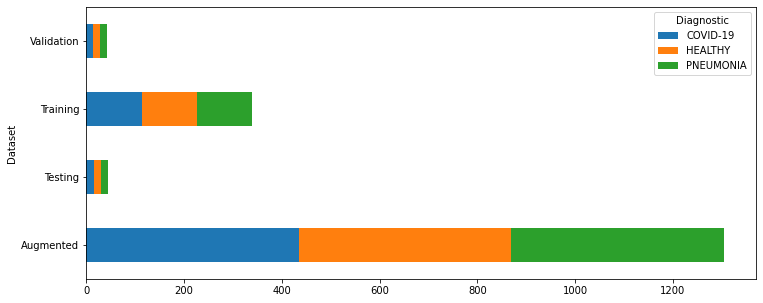

In [0]:
img_reader.plot_statistics()

Per últim el mètode plot_image_samples() visualitza algunes mostres del conjunt de dades augmentat per a cadascunda de les classes. Es mostren les imatges redimensionades amb tamany 224x224. S'observa que les imatges estan rotades i magnificades amb zoom.

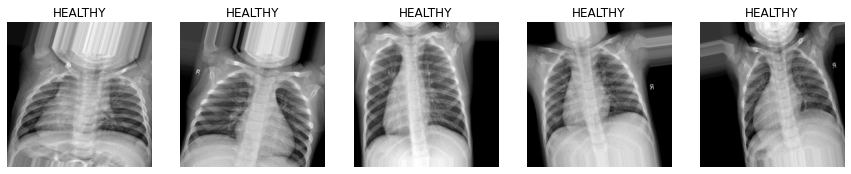

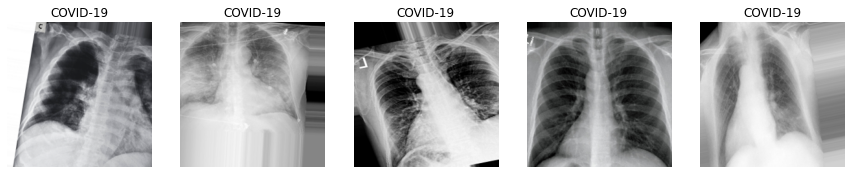

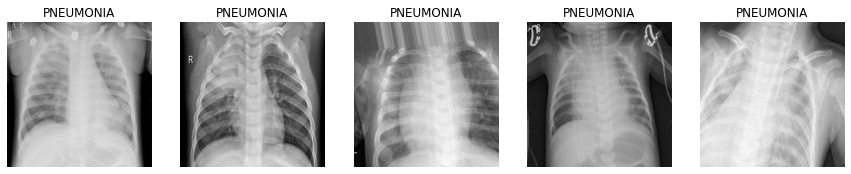

In [0]:
img_reader.plot_image_samples(samples=5)

# Creació dels models i mètriques d'avaluació (3 punts)

En aquesta secció es demana desenvolupar el *pipeline* per a la creació i entrenament del/s model/s. 

La literatura consultada sobre detecció de COVID-19 en radiografies sol utilitzar tècniques de *transfer learning* basades en l'ús de models de xarxes convolucionals (CNN) profundes preentrenades amb gran *datasets* com Imagenet. Posteriorment aquests models s'ajusten per a adaptar-los al problema de classificació específic, afegint noves capes, marcant algunes de les capes originals com no entrenables, etc. L'avantatge del *transfer learning* és que permet aplicar el conèixement adquirit a nous problemes paliant el problema de l'escassessa de dades d'entrenament. 

En aquest cas no aplicarem *tansfer learning* sinó que construirem els nostres propis models de CNN inspirades en arquitectures com VGG i SimpNet. Les xarxes tindràn la següent arquitectura:

* Una capa d'entrada amb dimensions (224,224,3).
* N blocs convolucionals, cadascun dels quals constarà de de M capes de convolució amb tamany de kernel (3,3)
i activació ReLU seguida per una capa de *max pooling* amb (2,2).
* Un bloc dens, format per K capes denses amb activació ReLu. Si s'aplica dropout cada capa densa estarà seguida per una capa de dropout amb probabilitat per defecte 0.3.
* Una capa de sortida amb 3 neurones, una per a cada classe, i activació *softmax*

Les capes convolucionals realitzen l'extracció de característiques de les imatges. Utilitzant diverses capes es facilita que puguin especialitzar-se en la detecció de patrons diferents. Les capes de *max pooling* redueixen la dimensionalitat renenent sol les característiques més rellevants i descartant la resta. Segons [...] aquesta operació és especialment important. Les capes denses preparen les dades per a la classificació.

Les dades d'entrada seràn les imatges generades per l'objecte CovidXRayImageReader a les que s'aplicarà
la normalització addicional de transformar els pixels
en el rang [0,1] dividint-los per 255. Les dades de
sortida seràn les classes de les imatges en el rang
0-2 que es transforaràn en vectors de longitud 3
aplicant *one hot encoding*.

La classe *CovidXRayModelBuilder* encapsula totes les operacions de construcció, entrenament i avaluació dels models. A continuació es presenta el codi i posteriorment veurem el seu ús.



In [0]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import sklearn.metrics as metrics
from collections import defaultdict

class CovidXRayModelBuilder:
    def __init__(self, img_reader):
        self.img_reader = img_reader
        self.models = defaultdict(dict)
        self.inputs, self.outputs = {}, {}
        self.model = None

    def get_inputs_outputs(self, ds):
        if ds not in self.inputs:
            #print('Loading dataset', ds, '...')
            dataset = self.img_reader.get_dataset(ds)
            images = dataset['image'].tolist()
            classes = dataset['class'].tolist()
            self.inputs[ds] = np.array(images) / 255.
            self.outputs[ds] = np.array(keras.utils.to_categorical(classes))
        return self.inputs[ds], self.outputs[ds]

    def get_labels(self, categorical_classes):
        labels = self.img_reader.get_labels()
        classes = map(np.argmax, categorical_classes.tolist())
        return list(map(lambda class_: labels[class_], classes))

    def get_input_shape(self):
        X, _ = self.get_inputs_outputs('testing')
        return X.shape[1:]

    def add_model(self, build_params):
        model_id = build_params['id']
        self.models[model_id]['build_params'] = build_params
        self.models[model_id]['model'] = self.build_model(build_params)

    def get_model_ids(self):
        return list(self.models.keys())

    def select_model(self, model_id):
        self.model = self.models[model_id]
        return self.model

    def build_model(self, build_params):
        dropout = build_params['dropout']
        # prefix per a generar el nom de les capes
        model_id = build_params['id'].lower()
        # crear model seqüèncial
        model = Sequential(name=model_id)
        # afegir capa d'entrada amb dimensions (height,width,channels)
        model.add(InputLayer(input_shape=self.get_input_shape()))
        # afegir blocs convolucionals seguits per una capa de max pooling
        i = 0
        for i in range(build_params['blocks']):
            prefix = model_id + '_' + 'block' + str(i+1) + '_'
            for j,units in enumerate(build_params['conv']):
                model.add(Conv2D(units, kernel_size=(3,3), 
                                 activation='relu', name=prefix+'conv' + str(j+1)))
            model.add(MaxPooling2D(pool_size=(2,2), name=prefix+'pool'))
            #if dropout > 0.0: model.add(Dropout(dropout, name=prefix+'dropout'))
        # aplanar sortida per a passar a la capes densa
        model.add(Flatten(name='flatten'))
        # afegir capes denses, opcionalment seguides de dropout

        for i,units in enumerate(build_params['dense']):
            prefix = model_id + '_'
            suffix = '_' + str(i+1)
            model.add(Dense(units, activation='relu', name=prefix+'dense'+suffix))
            if dropout > 0.0: model.add(Dropout(dropout, name=prefix+'dropout'+suffix))
        # afegir capa densa de sortida amb activació softmax
        model.add(Dense(len(self.img_reader.get_classes()), 
                            activation='softmax', name='predictions'))
        return model
        
    def compile_model(self, optimizer, metrics=['accuracy']):
        model = self.model['model']
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                      metrics=metrics)
    
    def fit_model(self, epochs=10, batch_size=32):
        import time
        model, build_params = self.model['model'], self.model['build_params']
        model_name = build_params['name']
        train_ds = 'augmented' if build_params['augmentation'] else 'training'
        X_train, y_train = self.get_inputs_outputs(train_ds)
        X_val, y_val = self.get_inputs_outputs('validation')        
        start = time.time()
        history = model.fit(
                       X_train, y_train,
                       validation_data=(X_val,y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=0) 
        end = int(time.time() - start)
        self.model['history'] = history.history
        self.model['training_time'] = end
        print('Model', model_name, 'training time', str(end), 'seconds')

    def get_all_models_train_history(self, *metrics):
        metric_names = []
        for metric in metrics: metric_names+= [metric, 'val_'+metric]
        epochs = len(self.model['history'][metrics[0]])
        histories = []
        columns = ['Epoch']
        for epoch in range(epochs):
            data = [epoch+1]
            for model_id in self.get_model_ids():
                model = self.models[model_id]
                history = model['history']
                for metric in metric_names:
                    if epoch == 1: columns.append(model_id + ' ' + metric)
                    data.append(history[metric][epoch])
            histories.append(data)
        return pd.DataFrame(histories, columns=columns)
    
    def plot_train_history(self, *metrics):
        model = self.model
        model_name = model['build_params']['name']
        history = model['history']
        training_time = model['training_time']
        _, axs = plt.subplots(1, len(metrics), figsize=(12,5))
        for ax, metric_name in zip(axs, metrics):
            metric = metric_name.lower()
            epochs = range(1,len(history[metric])+1)
            ax.plot(epochs, history[metric], label='train ' + metric)
            ax.plot(epochs, history['val_'+metric], label='validation ' + metric)
            ax.legend()
            ax.set_title(model_name + ': ' + metric_name)
        plt.show()
    
    def eval_model(self):
        X_test, y_test = self.get_inputs_outputs('testing')
        y_test = self.get_labels(y_test)
        predictions = self.model['model'].predict(X_test)
        y_pred = self.get_labels(predictions)
        labels = self.img_reader.get_labels()
        avg = 'weighted'
        build_params = self.model['build_params']
        scores = {'Model': build_params['id'], 'Name': build_params['name']}
        scores['Training Time Secs'] = self.model['training_time']
        scores['Accuracy'] = metrics.accuracy_score(y_test,y_pred)
        scores['Precision'] = metrics.precision_score(y_test,y_pred,average=avg)
        scores['Recall'] = metrics.recall_score(y_test,y_pred,average=avg)
        scores['F1 Score'] = metrics.f1_score(y_test,y_pred,average=avg)
        self.model['eval_scores'] = scores
        self.model['confusion_matrix'] = metrics.confusion_matrix(y_test, y_pred, labels=labels) 
        self.model['predictions'] = predictions
        return scores

    def plot_confusion_matrix(self, ax=None):
        import seaborn as sn
        labels = self.img_reader.get_labels()
        matrix = self.model['confusion_matrix']
        title = self.model['build_params']['name']
        df_matrix = pd.DataFrame(matrix, columns=labels, index=labels)
        df_matrix.index.name = 'Reality'
        df_matrix.columns.name = 'Prediction'
        if ax is None:
            sn.heatmap(df_matrix, cmap='Blues', annot=matrix)
        else:
            sn.heatmap(df_matrix, cmap='Blues', annot=matrix, ax=ax)

La classe presentada facilita la construcció i comparació de xarxes CNN basades en l'arquitectura de blocs convolucionals seguits per capes denses amb o sense dropout.

En concret compararem les següents arquitectures:

* **Baseline**: 1 bloc amb 1 capa convolucional de 32 neurones amb kernel 3x3 + una capa 2x2 de *max pooling* seguida per una capa densa amb 64 neurones i la capa de sortida. S'entrenarà amb el conjunt no augmentat.
* **Baseline, augmented**: mateixa arquitectura que l'anterior però s'entrenarà amb el conjunt augmentat això ens permetrà comprovar si l'augmentació de dades millora el comportament del model.
* **2 Conv2D blocks, no dropout**: 2 blocs convolucionals formats per dues capes de convolució amb 32 i 64 neurones i tamany de kernel 3x3. A continuació de cada bloc, una capa 2x2 de *max pooling*. Finalment, una capa densa de 64 neurones seguida per la capa de sortida. No s'aplicarà dropout.
* **2 Conv2D blocks, dropout**: mateixa arquitectura que l'anterior però la capa densa de 64 neurones va seguida d'una capa de dropout amb probabilitat 0.3. Això ens permetrà comprovar l'efecte del *dropout*.

El següent codi instància la classe CovidXRayModelBuilder amb el generador d'imatges, construeix els models citats i mostra el sumari d'un d'ells. 

Amb aquesta classe es pot generar fàcilment a altres arquitectures basades en blocs convolucionals amb només afegir nous elements a la llista MODEL_PARAMS. També és senzill modificar el codi de la classe per a parametritzar el tamany dels kernels i del pool.



In [0]:
PARAM_NAMES = ['id', 'name', 'conv', 'blocks', 'dense', 'dropout', 'augmentation']
MODEL_PARAMS=[
    ['BLNOAUG', 'Baseline, no augmentation', (32,), 1, (64,), 0., False],
    ['BLAUG', 'Baseline, augmented', (32,), 1, (64,), 0., True],
    ['2CONVNODROP', '2 Conv2D blocks, no dropout', (32,64), 2, (64,), 0., True],
    ['2CONVDROP', '2 Conv2D blocks, dropout=0.3', (32,64), 2, (64,), 0.25, True],
]
builder = CovidXRayModelBuilder(img_reader)
for params in MODEL_PARAMS:
    build_params = {name: value for name,value in zip(PARAM_NAMES, params)}
    builder.add_model(build_params)
builder.select_model('2CONVDROP')['model'].summary()

Model: "2convdrop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
2convdrop_block1_conv1 (Conv (None, 222, 222, 32)      896       
_________________________________________________________________
2convdrop_block1_conv2 (Conv (None, 220, 220, 64)      18496     
_________________________________________________________________
2convdrop_block1_pool (MaxPo (None, 110, 110, 64)      0         
_________________________________________________________________
2convdrop_block2_conv1 (Conv (None, 108, 108, 32)      18464     
_________________________________________________________________
2convdrop_block2_conv2 (Conv (None, 106, 106, 64)      18496     
_________________________________________________________________
2convdrop_block2_pool (MaxPo (None, 53, 53, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 179776)            0 

Una vegada construïts el model cal compilar-los i entrenar-los. El següent codi fa les següents operacions:

* Compila el model amb optimitzador Adam i velocitat d'aprenentatge 0.0001.
* Entrena els models durant 10 èpoques amb tamany de batch 64 validant amb el dataset *validation*.
* Mostra les gràfiques de l'evolució de la precisió (accuracy) i perdua (loss) durant les èpoques d'entrenament per a cada model

Model Baseline, no augmentation training time 5 seconds


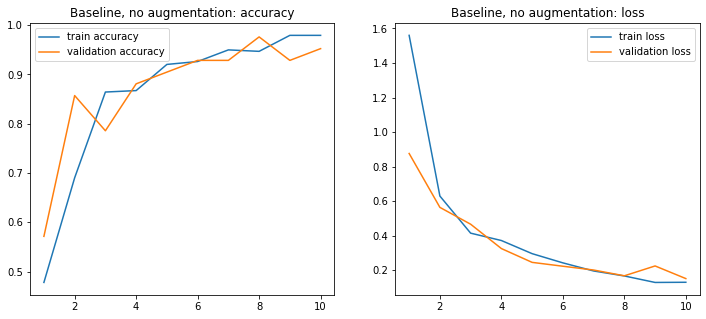

Model Baseline, augmented training time 13 seconds


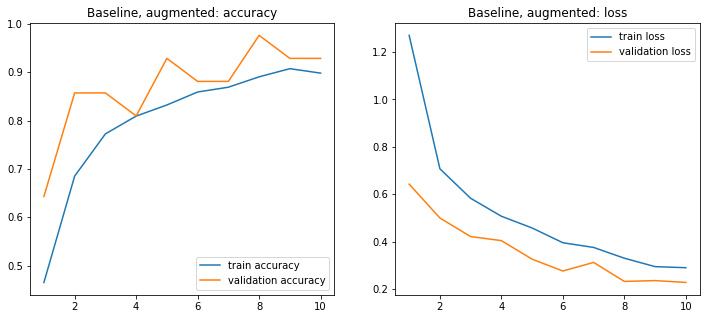

Model 2 Conv2D blocks, no dropout training time 34 seconds


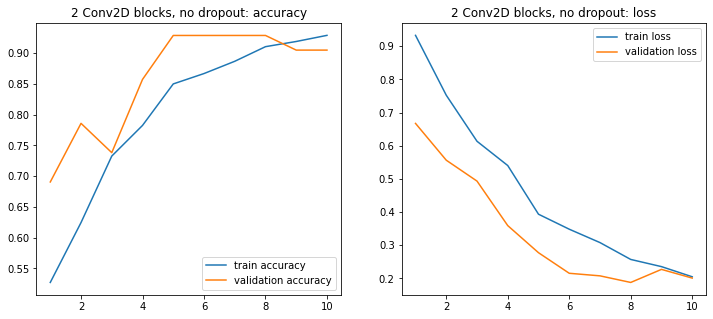

Model 2 Conv2D blocks, dropout=0.3 training time 32 seconds


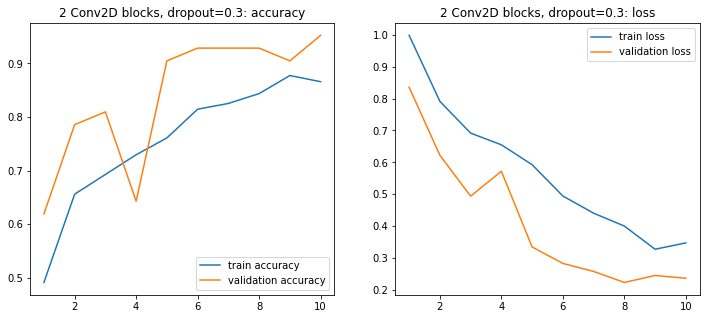

In [0]:
METRICS = 'accuracy', 'loss'
for model_id in builder.get_model_ids():
    builder.select_model(model_id)
    builder.compile_model(tf.keras.optimizers.Adam(lr=1e-4))
    builder.fit_model(epochs=10, batch_size=64)
    builder.plot_train_history(*METRICS)

A les corbes d'entrenament s'observa que el model que presenta menys indicis d'overfitting i inestabilitat és el darrer 2CONVDROP, amb arquitectura de 2 blocs convolucionals i dropout 0.3

La següent tabla presenta els valors de precisió i perdua a cada època de l'entrenament:

In [0]:
builder.get_all_models_train_history(*METRICS)

,Epoch,BLNOAUG accuracy,BLNOAUG val_accuracy,BLNOAUG loss,BLNOAUG val_loss,BLAUG accuracy,BLAUG val_accuracy,BLAUG loss,BLAUG val_loss,2CONVNODROP accuracy,2CONVNODROP val_accuracy,2CONVNODROP loss,2CONVNODROP val_loss,2CONVDROP accuracy,2CONVDROP val_accuracy,2CONVDROP loss,2CONVDROP val_loss
0,1,0.477876,0.571429,1.560129,0.876224,0.465134,0.642857,1.270282,0.642389,0.527203,0.690476,0.932952,0.667371,0.491188,0.619048,0.998483,0.835628
1,2,0.690265,0.857143,0.629736,0.564184,0.685057,0.857143,0.707312,0.499610,0.624521,0.785714,0.752363,0.556402,0.655939,0.785714,0.791318,0.621958
2,3,0.864307,0.785714,0.414942,0.466711,0.772414,0.857143,0.582713,0.421174,0.732567,0.738095,0.613485,0.493388,0.692720,0.809524,0.691625,0.493834
3,4,0.867257,0.880952,0.372287,0.325749,0.809195,0.809524,0.506940,0.404065,0.782375,0.857143,0.540292,0.359157,0.729502,0.642857,0.654962,0.571900
4,5,0.920354,0.904762,0.296237,0.245781,0.832184,0.928571,0.457399,0.325710,0.849808,0.928571,0.393527,0.277440,0.760920,0.904762,0.592519,0.334246
5,6,0.926254,0.928571,0.242917,0.223459,0.859004,0.880952,0.395121,0.275883,0.866667,0.928571,0.348319,0.215373,0.814559,0.928571,0.494194,0.282596
6,7,0.949853,0.928571,0.195972,0.201476,0.868966,0.880952,0.375284,0.312116,0.886590,0.928571,0.307950,0.207637,0.825287,0.928571,0.440327,0.257485
7,8,0.946903,0.976190,0.167117,0.168001,0.890421,0.976190,0.329852,0.231887,0.910345,0.928571,0.257102,0.187740,0.843678,0.928571,0.399868,0.222932
8,9,0.979351,0.928571,0.129550,0.225072,0.907280,0.928571,0.294281,0.235371,0.918774,0.904762,0.235470,0.227112,0.877395,0.904762,0.327163,0.244810
9,10,0.979351,0.952381,0.130540,0.151892,0.898084,0.928571,0.289784,0.227581,0.928736,0.904762,0.204829,0.200848,0.865900,0.952381,0.347024,0.236061


# Resultats i Conclusions (3 punts)

En aquesta secció cal implementar la fase de test dels millors models desenvolupats i entrenants en la fase anterior. 

Es valoraran aspectes com:

- Raonament de quina arquitectura és la més adecuada
- Anàlisis quantitatiu i qualitatiu dels resultats

Avaluarem els dos models que han donat millor resultats, 2CONVNODROP i 2CONVDROP.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


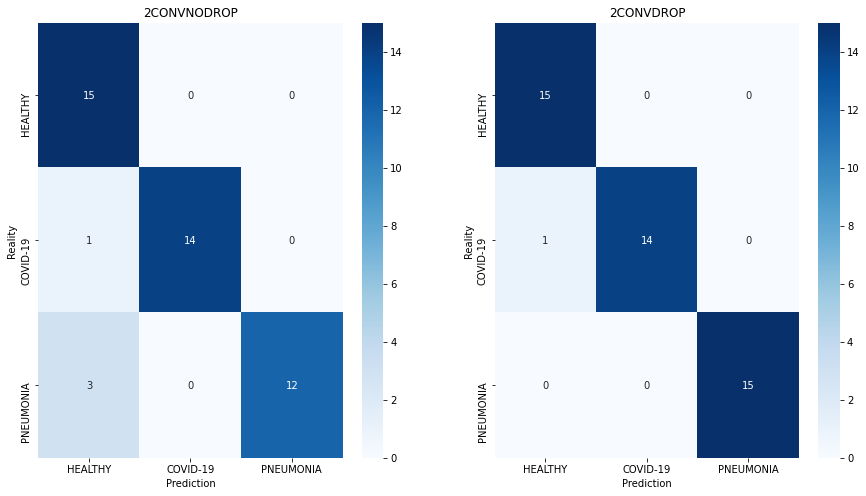

In [0]:
model_ids = '2CONVNODROP', '2CONVDROP'
scores = []
_, axs = plt.subplots(1, len(model_ids), figsize=(15,8))
for model_id,ax in zip(model_ids, axs):
    builder.select_model(model_id)
    scores.append(builder.eval_model())
    builder.plot_confusion_matrix(ax=ax)
    ax.set_title(model_id)

La següent taula mostra les puntuacions obtingudes pel model en les principals mètriques

In [0]:
scores_df = pd.DataFrame(scores)
scores_df

,Model,Name,Training Time Secs,Accuracy,Precision,Recall,F1 Score
0,2CONVNODROP,"2 Conv2D blocks, no dropout",34,0.911111,0.929825,0.911111,0.912253
1,2CONVDROP,"2 Conv2D blocks, dropout=0.3",32,0.977778,0.979167,0.977778,0.977753


El model que ha obtingut millors resultats és el dos blocs de convolució i dropout de 0.3. Ha demostrat molt bona capacitat de generalització amb dades no vistes, arribant a una precisió, recall i score F1 proper al 98%. A destacar que ha classificat correctament a tots els pacients sans i amb neumònia, i quasi tots els de COVID-19 de les dades de test.

Crec que l'èxit d'aquest model pot deure's a que és l'arquitectura més profunda i el dropout evita el sobreentrenament que és un risc habitual als models de *deep learning*

# *Explainability* (1 punt)


Investiga sobre les tècniques que es fan servir per entendre les decicions d'una CNN. Per exemple, Els [Class Activation Maps](https://arxiv.org/pdf/1512.04150.pdf) (CAM)[4] són una modificació en l'arquitectura d'una CNN de classificació de imatges que ens permet visualitzar quines parts de la imatge es consideren per classificar una classe amb una determinada etiqueta. Variacions de les CAMS s'han aplicat recentment per entendre el comportament de les xarxes per detectar Covid19[8].

Una altre mètode és el popular [Deep Dream](https://deepdreamgenerator.com/)[11]. Aquest mètode, a part de generar imatges amb un estil bastant artístic/psicodèlic, serveix per entendre el tipus de característiques que una xarxa busca en la imatge d'entrada per classificar-la amb una determinada etiqueta.

Implementa alguna tècnica de visualització per intentar entendre les decisions de la CNN entrenada.

  Using cached https://github.com/raghakot/keras-vis/archive/master.zip
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30855 sha256=4449b9f02845898c7ad3219150b2d22d951a8f12c6380b34ba9021b397b1a6e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-kz_7n_am/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis


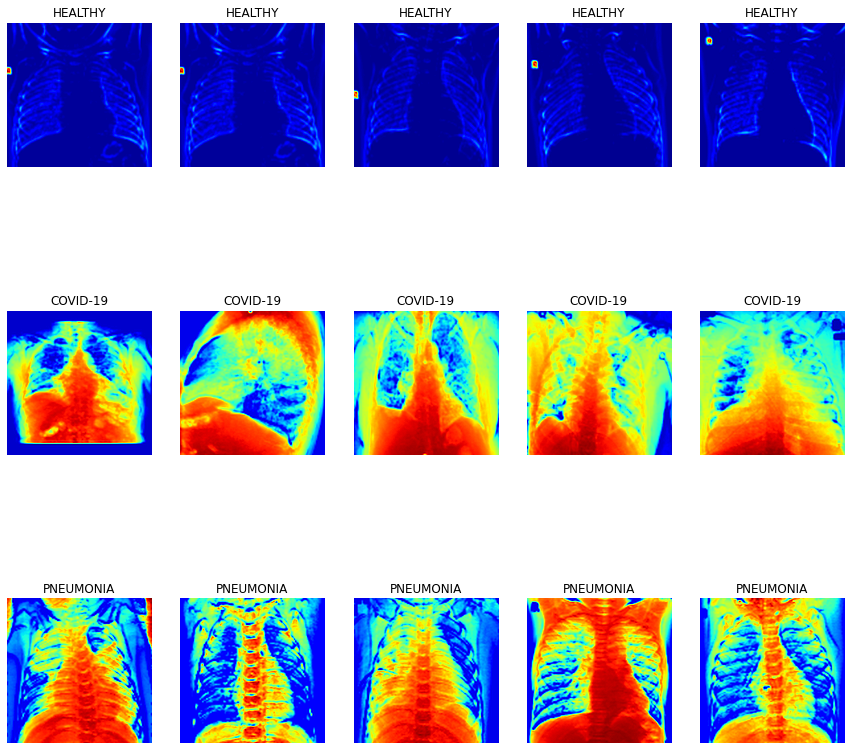

In [0]:
!pip install https://github.com/raghakot/keras-vis/archive/master.zip
from vis.visualization import visualize_cam
from vis.utils import utils

SAMPLES = 5
selected_model = builder.select_model('2CONVDROP')
model = selected_model['model']
predictions = selected_model['predictions']
X_test, y_test = builder.get_inputs_outputs('testing')
X_test = X_test * 255.
layer_idx = utils.find_layer_idx(model, '2convdrop_block2_conv2')
# This corresponds to the Dense linear layer.
_, ax = plt.subplots(3, 5, figsize=(15,15))
for class_idx, label in zip(img_reader.get_classes(), img_reader.get_labels()): 
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    indices = np.random.choice(indices, size=SAMPLES)
    for sample in range(SAMPLES):
        idx = indices[sample]
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=X_test[idx])
        ax[class_idx][sample].imshow(grads, cmap='jet')
        ax[class_idx][sample].set_title(label)
        ax[class_idx][sample].axis('off')


Els maps CAM han il.luminat tots els casos de COVID-19 i de neumonia, però no els de pacients sans. Això sembla coherent. Respecte a les diferències entre COVID i neumonia sembla que els casos de COVID estàn més il.luminats i això podria indicar més afectacions del pulmons però sense coneixements mèdics no gosen fer tal afirmació.